# Práctica 2: Sensado y análisis de video
## Detección de puntos de atención visual

### Acerca de la actividad.

La tarea de detección de puntos de atenciòn visual concite en utilizar herramientas de visión por computadora. En este notebook analizaremos como llevar acabo esta tarea utilizando herramientas como mediapipe para la detecciòn de rostros y extraer sus caracteristicas, asi como algoritmos de machine learning para realizar tareas de clasificación de los puntos visuales captados.

### Dataset
Se recolectaron videos de un minuto donde se realizaron multiples puntos de atención visual dentro de un automovil. Esto con el objetivo de clasificar hacia donde esta la atención visual de la persona en cuestion. 
Las etiquetas son: 
- FRENTE
- IZQUIERDA
- DERECHA
- RETROVISOR
- PALANCA

Estas clases representan nuestros puntos de atención visual, la forma en la que se capturaron los videos fue grabandolos dentro de un auto con el motor apagado con una camara frente al asiento del conductor a la altura de los ojos. 

### Librerias

In [40]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import mediapipe as mp
import sys
import os
import copy
import itertools
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Segmentado y preparación de los Datos.

En las siguientes celdas se muestran los scripts utilizados para segementar los videos.

Cada video recolectado viene acompañado con archivo .csv que indica el tiempo en donde se efectua el punto de atención visual, por lo que vamos a homogeneisar cada uno de los archivos y transformarlos en un dataframes que podamos recorrer para segementar cada clip de acuerdo a su etiqueta. 

In [2]:
IMGS = "./Imagen/"
dir_list = os.listdir(IMGS)
dir_list.sort()
dfsCsv = []
for i in dir_list:
    fnames = os.listdir(IMGS + i)
    for f in fnames:
        if f.endswith(".csv"):
            df = pd.read_csv(IMGS + i + f"/{f}")
            name = f.replace('csv', 'mp4')
            df['source'] = IMGS + i + f"/{name}"
            df['subject'] = name[:-4]
            dfsCsv.append(df)

Como se puede observar en las siguientes celdas, los formatos suelen tener variaciones entre si, por lo que debemos de escoger un formato a utilizar y adaptar los demas a este mismo. 

In [3]:
dfsCsv[1]

,Unnamed: 0,FRENTE,IZQUIERDA,DERECHA,RETROVISOR,PALANCA,source,subject
0,0,00:00 - 00:08,00:11- 00:19,00:22-00:29,00:31-00:38,00:41-00:48,./Imagen/Ariana/ARIANA.mp4,ARIANA


In [4]:
# Dataframe con formato diferente
df_last = dfsCsv[-1]
dfsCsv = dfsCsv[:-1]
df_last

,filename,inicio,fin,label,source,subject
0,SCARLETT.mp4,00:00,00:12,frente,./Imagen/Scarlett/SCARLETT.mp4,SCARLETT
1,SCARLETT.mp4,00:13,00:24,izquierdo,./Imagen/Scarlett/SCARLETT.mp4,SCARLETT
2,SCARLETT.mp4,00:25,00:35,central,./Imagen/Scarlett/SCARLETT.mp4,SCARLETT
3,SCARLETT.mp4,00:37,00:47,derecho,./Imagen/Scarlett/SCARLETT.mp4,SCARLETT
4,SCARLETT.mp4,00:48,01:00,palanca,./Imagen/Scarlett/SCARLETT.mp4,SCARLETT


El formato de la celda anterior se asemeja mucho al formato que queremos lograr. 

A continuación adaptamos los formatos de los archivos al formato deseado. 

In [106]:
# Definir el mapeo de valores
mapeo_valores = {
    'frente': 'FRENTE',
    'izquierdo': 'IZQUIERDA',
    'central': 'RETROVISOR',
    'derecho': 'DERECHA',
    'palanca': 'PALANCA'
}

# Mapear los valores de la columna 'label'
df_last['label'] = df_last['label'].map(mapeo_valores)

df_last = df_last[['inicio', 'fin', 'label', 'source', 'subject']]
df_last 

,inicio,fin,label,source,subject
0,00:00,00:12,NaN,./Imagen/Scarlett/SCARLETT.mp4,SCARLETT
1,00:13,00:24,NaN,./Imagen/Scarlett/SCARLETT.mp4,SCARLETT
2,00:25,00:35,NaN,./Imagen/Scarlett/SCARLETT.mp4,SCARLETT
3,00:37,00:47,NaN,./Imagen/Scarlett/SCARLETT.mp4,SCARLETT
4,00:48,01:00,NaN,./Imagen/Scarlett/SCARLETT.mp4,SCARLETT


In [107]:
dfs_concat = []
dfs_concat.append(df_last)
for df in dfsCsv:
    source = df['source'][0]
    subject = df['subject'][0]
    columns_to_keep = ['FRENTE', 'RETROVISOR', 'IZQUIERDA', 'DERECHA', 'PALANCA']
    df = df[columns_to_keep]

    # Usar melt para cambiar el formato del DataFrame
    df = df.melt(var_name='label', value_name='intervalo')

    # Separar la columna 'intervalo' en 'inicio' y 'fin'
    df[['inicio', 'fin']] = df['intervalo'].str.split('-', expand=True)

    # Eliminar la columna 'intervalo'
    df.drop(columns='intervalo', inplace=True)

    # Reordenar las columnas
    df = df[['inicio', 'fin', 'label']]

    df['source'] = source
    df['subject'] = subject
    df = df.dropna(axis=0)
    dfs_concat.append(df)
    # Las columnas de este dataframe son: [inicio, fin, label, source, subject]

Despues de que todos hayan sido adaptados al formato, los concatenamos y reseteamos el indice para que no exista inconsistencias posteriores. 

In [7]:
IMG_df = pd.concat(dfs_concat)
IMG_df.reset_index(drop=True, inplace=True)

Teniedo nuestro Dataframe listo, lo que haremos sera recorrer cada una de sus filas para acceder a la ruta de los videos, el tiempo donde se efectua la acción en el video y sus respectivas etiquetas. 

In [8]:
# Crear la carpeta para guardar los videos recortados
output_folder = './sources'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Iterar sobre cada fila del DataFrame
for index, row in IMG_df.iterrows():
    subject = row['subject']
    inicio = row['inicio']
    fin = row['fin']
    label = row['label']
    source = row['source']
    
    # Cargar el video
    video_capture = cv2.VideoCapture(source)
    
    # Obtener la tasa de fotogramas del video
    fps = video_capture.get(cv2.CAP_PROP_FPS)
    
    # Verificar que el formato de inicio y fin sea válido
    if ':' not in inicio or ':' not in fin:
        print(f"Error en el formato de tiempo en la fila {index}. Saltando esta fila.")
        continue
    
    # Convertir los tiempos de inicio y fin a segundos
    inicio_segundos = int(inicio.split(':')[0]) * 60 + int(inicio.split(':')[1])
    fin_segundos = int(fin.split(':')[0]) * 60 + int(fin.split(':')[1])
    
    # Crear el nombre del archivo de salida
    folder_PAV = f'./sources/{label}'
    if not os.path.exists(folder_PAV):
        os.makedirs(folder_PAV)
    output_filename = f"{folder_PAV}/{subject}_{index}.mp4"
    IMG_df.at[index, 'source'] = output_filename
    # Crear un objeto VideoWriter para guardar el video recortado
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(output_filename, fourcc, fps, (int(video_capture.get(3)), int(video_capture.get(4))))
    
    # Establecer el cuadro actual en el tiempo de inicio
    video_capture.set(cv2.CAP_PROP_POS_FRAMES, inicio_segundos * fps)
    
    # Leer y escribir cada cuadro hasta el tiempo de finalización
    while video_capture.get(cv2.CAP_PROP_POS_FRAMES) < fin_segundos * fps:
        ret, frame = video_capture.read()
        if ret:
            video_writer.write(frame)
        else:
            break
    
    # Liberar los recursos
    video_capture.release()
    video_writer.release()

print("Videos recortados y guardados en la carpeta 'sources'.")

Videos recortados y guardados en la carpeta 'sources'.


Despues de hacer esto, guardamos nuestro Dataframe en un archivo .csv para posterior analisis. 

In [9]:
IMG_df.to_csv('./dataframes/IMG_df.csv') #Se guarda en un archivo .csv para posterior analisis

### Analisis exploratorio

Se realizo un pequeño analisis exploratorio acerca de las frecuencias de las etiquetas y los sujetos con el objetivo de tener una mejor analisis del balance que existe en nuestros datos. 

In [10]:
IMG_df = pd.read_csv('./dataframes/IMG_df.csv')
IMG_df = IMG_df[['inicio',	'fin',	'label',	'source',	'subject',]]
IMG_df

,inicio,fin,label,source,subject
0,00:00,00:12,FRENTE,./sources/FRENTE/SCARLETT_0.mp4,SCARLETT
1,00:13,00:24,IZQUIERDA,./sources/IZQUIERDA/SCARLETT_1.mp4,SCARLETT
2,00:25,00:35,RETROVISOR,./sources/RETROVISOR/SCARLETT_2.mp4,SCARLETT
3,00:37,00:47,DERECHA,./sources/DERECHA/SCARLETT_3.mp4,SCARLETT
4,00:48,01:00,PALANCA,./sources/PALANCA/SCARLETT_4.mp4,SCARLETT
5,00:00,00:08,FRENTE,./sources/FRENTE/ANDRES_5.mp4,ANDRES
6,00:14,00:16,FRENTE,./sources/FRENTE/ANDRES_6.mp4,ANDRES
7,00:22,00:23,FRENTE,./sources/FRENTE/ANDRES_7.mp4,ANDRES
8,00:29,00:36,FRENTE,./sources/FRENTE/ANDRES_8.mp4,ANDRES
9,00:24,00:28,RETROVISOR,./sources/RETROVISOR/ANDRES_9.mp4,ANDRES


En las siguientes celcas podemos observar que existe un ligero desbalance entre las muestras de cada etiqueta. Lo que ya desde un inicio puedo inferir en que podria ser un detalle por el cual pudiese segsar de manera minima el entrenamiento de un modelo. 

In [11]:
IMG_df.label.value_counts()

label
FRENTE        9
IZQUIERDA     8
RETROVISOR    8
DERECHA       8
PALANCA       7
Name: count, dtype: int64

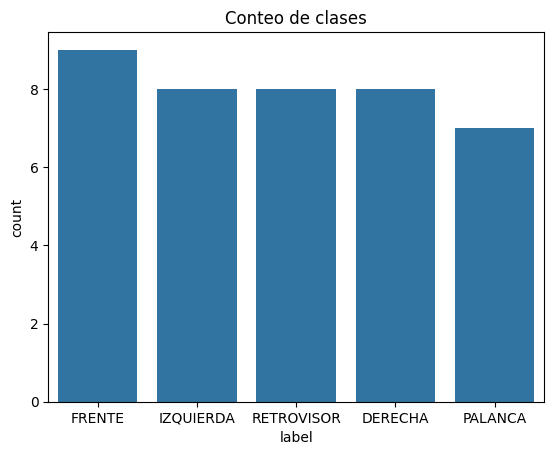

In [12]:
sns.countplot(IMG_df, x='label')
plt.title("Conteo de clases")
plt.show()

Además cabe mencionar que la frecuencia de las muestras con base en los sujetos tambien esta muy desbalanciada

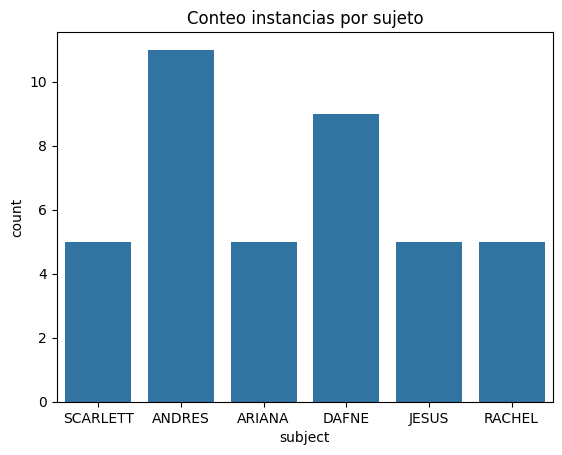

In [13]:
sns.countplot(IMG_df, x='subject')
plt.title('Conteo instancias por sujeto')
plt.show()

### Extracción de caracteristicas

A continuación se muestra el proceso de extración de caracteristicas utilizando mediapipe face detection

In [14]:
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

# Inicializar el detector de rostros. Usaremos el modelo de detección precisa en este ejemplo.
face_detection = mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

La función calc_landmark_list lo que hace es generar una lista de los puntos de referencia extraidos de mediapipe y normalizarlos de acuerdo al tamaño la imagen (En este caso cada frame del video). Esto se hizo asi ya que en algunas muestras se detecto que el bounding_box de mediapipe resultaba ser impreciso  y abarcaba gran parte de la pantalla, por lo que no parecia buena idea normalizarlos en base a este. 

In [35]:
def calc_landmark_list(image, landmarks):
    image_width, image_height = image.shape[1], image.shape[0]
    landmark_point = []
    # Keypoint
    for point in landmarks:
        landmark_x = min(int(point.x * image_width), image_width - 1)
        landmark_y = min(int(point.y * image_height), image_height - 1)
        
        landmark_point.append([landmark_x, landmark_y])

    return landmark_point

La función pre_process_landmark lo que hace transformar la lista de puntos de referencia en una lista con datos relativos y normalizados. Para volverlos relativos se considero al primer keypoint de la salida de mediapipe como nuesta referencia (0,0) que según experimentos, este primer keypoint representa el ojo izquierdo.

In [38]:
def pre_process_landmark(landmark_list):
    temp_landmark_list = copy.deepcopy(landmark_list)

    # Convert to relative coordinates
    base_x, base_y = 0, 0
    for index, landmark_point in enumerate(temp_landmark_list):
        if index == 0:
            base_x, base_y = landmark_point[0], landmark_point[1]

        temp_landmark_list[index][0] = temp_landmark_list[index][0] - base_x
        temp_landmark_list[index][1] = temp_landmark_list[index][1] - base_y

    # Convert to a one-dimensional list
    temp_landmark_list = list(
        itertools.chain.from_iterable(temp_landmark_list))

    # Normalization
    max_value = max(list(map(abs, temp_landmark_list)))

    def normalize_(n):
        return n / max_value

    temp_landmark_list = list(map(normalize_, temp_landmark_list))

    return temp_landmark_list

In [57]:
# Creamos un dataframe sencillo para una sola landmark list. 
def create_dataframe(temp_landmark_list, label):
    columnas = ["label"] + [f"k{i}" for i in range(12)]
    datos = [label, *temp_landmark_list]
    return pd.DataFrame([datos], columns=columnas)

En la siguiente celda realizamos la extración de caracteristicas con mediapipe, donde por cada frame realizamos las funciones vistas anteriormente y generamos un dataframe con todas las coordenadas de cada clip segmentado.

In [64]:
features_df = []
landmarks = None
landmarks_normalized = None
img = None
first = 1
for index, row in IMG_df.iterrows():
    video_path = row['source']
    label = row['label'] 
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error al abrir el video")
    else:
        with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detection:
            while True:
                success, image = cap.read()
                if not success:
                    print("Fin del video.")  # Indica el fin del video y sale del bucle
                    break

                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image.flags.writeable = False

                results = face_detection.process(image)

                image.flags.writeable = True
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                if results.detections:
                    for detection in results.detections:
                        mp_drawing.draw_detection(image, detection)
                        relative_keypoints = detection.location_data.relative_keypoints
                        landmark_point = calc_landmark_list(image, relative_keypoints)
                        temp_landmark_list = pre_process_landmark(landmark_point)
                        df = create_dataframe(temp_landmark_list, label)
                        features_df.append(df)
                        if first == 1: 
                            img = image
                            landmarks = relative_keypoints
                            first += 1
                cv2.imshow('Face Detection in Video', image)

                if cv2.waitKey(1) & 0xFF == ord('q'):  # Permite la opción de terminar prematuramente con la tecla 'q'
                    break

        cap.release()
        cv2.destroyAllWindows()

Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.
Fin del video.


Dataframe final:

In [65]:
definitive_df = pd.concat(features_df)
definitive_df

,label,k0,k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11
0,FRENTE,0.0,0.0,0.575862,-0.041379,0.255172,0.275862,0.289655,0.593103,-0.213793,0.210345,1.0,0.120690
0,FRENTE,0.0,0.0,0.578397,-0.041812,0.257840,0.278746,0.296167,0.595819,-0.219512,0.212544,1.0,0.118467
0,FRENTE,0.0,0.0,0.576389,-0.045139,0.260417,0.277778,0.298611,0.593750,-0.218750,0.211806,1.0,0.114583
0,FRENTE,0.0,0.0,0.578397,-0.041812,0.261324,0.282230,0.299652,0.599303,-0.222997,0.209059,1.0,0.114983
0,FRENTE,0.0,0.0,0.578397,-0.041812,0.264808,0.282230,0.299652,0.599303,-0.222997,0.209059,1.0,0.114983
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,PALANCA,0.0,0.0,0.501718,-0.103093,0.202749,0.254296,0.288660,0.484536,-0.082474,0.134021,1.0,-0.072165
0,PALANCA,0.0,0.0,0.498294,-0.109215,0.201365,0.249147,0.290102,0.477816,-0.075085,0.133106,1.0,-0.085324
0,PALANCA,0.0,0.0,0.503401,-0.098639,0.204082,0.265306,0.292517,0.493197,-0.085034,0.129252,1.0,-0.074830
0,PALANCA,0.0,0.0,0.505119,-0.102389,0.204778,0.262799,0.290102,0.494881,-0.092150,0.133106,1.0,-0.068259


In [71]:
definitive_df.to_csv('./dataframes/Keypoints_df.csv') # Lo guardamos en un archivo .csv

Para verificar que nuestros datos transformados representan bien los datos en crudo, se realizo un pequeño analisis exploratorio de las salidas de estas funciones utilizando un solo frame. Estas pueden verse a continuación:

In [68]:
landmark_point = calc_landmark_list(img, landmarks)
landmark_point

[[272, 618], [439, 606], [346, 698], [356, 790], [210, 679], [562, 653]]

In [69]:
temp_landmark_list = pre_process_landmark(landmark_point)
temp_landmark_list

[0.0,
 0.0,
 0.5758620689655173,
 -0.041379310344827586,
 0.25517241379310346,
 0.27586206896551724,
 0.2896551724137931,
 0.593103448275862,
 -0.21379310344827587,
 0.2103448275862069,
 1.0,
 0.1206896551724138]

Decidimos visualizar los datos en crudo y los datos transformados en una grafica de dispersión para ver si las coordendas en ambos conjuntos se situan de manera similar o igual. 

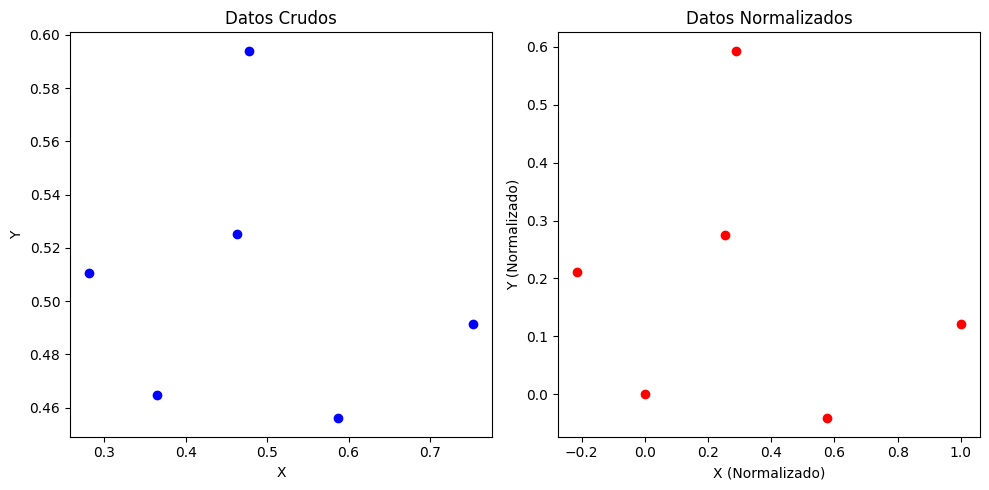

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# Datos crudos
keypoint = landmarks
landmarks_x = [point.x for point in keypoint]
landmarks_y = [point.y for point in keypoint]
# Datos normalizados
normalized_data = temp_landmark_list
normalized_data_x = normalized_data[::2]  # Extraer los valores de x de los datos normalizados
normalized_data_y = normalized_data[1::2]  # Extraer los valores de y de los datos normalizados

# Crear gráfico de dispersión para los datos crudos
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(landmarks_x, landmarks_y, color='blue')
plt.title('Datos Crudos')
plt.xlabel('X')
plt.ylabel('Y')

# Crear gráfico de dispersión para los datos normalizados
plt.subplot(1, 2, 2)
plt.scatter(normalized_data_x, normalized_data_y, color='red')
plt.title('Datos Normalizados')
plt.xlabel('X (Normalizado)')
plt.ylabel('Y (Normalizado)')

plt.tight_layout()
plt.show()


Con este resultado se pudo inferir que los datos transformados si representan de manera fiel los datos en crudo. 

### Entrenamiento de los modelos

En las siguientes celdas se observa el entrenamiento y evaluación de un conjunto de modelos de machine learning utilizando distintos algoritmos. Esto con el objetivo de seleccionar el mejor modelo.  

In [72]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

In [79]:
keypoints_df = pd.read_csv('./dataframes/Keypoints_df.csv')
keypoints_df = keypoints_df[['label',	'k0',	'k1',	'k2',	'k3',	'k4',	'k5',	'k6',	'k7',	'k8',	'k9',	'k10',	'k11']]
keypoints_df

,label,k0,k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11
0,FRENTE,0.0,0.0,0.575862,-0.041379,0.255172,0.275862,0.289655,0.593103,-0.213793,0.210345,1.0,0.120690
1,FRENTE,0.0,0.0,0.578397,-0.041812,0.257840,0.278746,0.296167,0.595819,-0.219512,0.212544,1.0,0.118467
2,FRENTE,0.0,0.0,0.576389,-0.045139,0.260417,0.277778,0.298611,0.593750,-0.218750,0.211806,1.0,0.114583
3,FRENTE,0.0,0.0,0.578397,-0.041812,0.261324,0.282230,0.299652,0.599303,-0.222997,0.209059,1.0,0.114983
4,FRENTE,0.0,0.0,0.578397,-0.041812,0.264808,0.282230,0.299652,0.599303,-0.222997,0.209059,1.0,0.114983
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9234,PALANCA,0.0,0.0,0.501718,-0.103093,0.202749,0.254296,0.288660,0.484536,-0.082474,0.134021,1.0,-0.072165
9235,PALANCA,0.0,0.0,0.498294,-0.109215,0.201365,0.249147,0.290102,0.477816,-0.075085,0.133106,1.0,-0.085324
9236,PALANCA,0.0,0.0,0.503401,-0.098639,0.204082,0.265306,0.292517,0.493197,-0.085034,0.129252,1.0,-0.074830
9237,PALANCA,0.0,0.0,0.505119,-0.102389,0.204778,0.262799,0.290102,0.494881,-0.092150,0.133106,1.0,-0.068259


In [80]:
X = keypoints_df.iloc[:, 1:]
Y = keypoints_df.iloc[:, 0]
encoder = LabelEncoder()
y_encode = encoder.fit_transform(Y)
y_encode

array([1, 1, 1, ..., 3, 3, 3])

Estos son algoritmos utilizados:

In [81]:
names = [
    "Nearest Neighbors",
    "Decision Tree",
    "AdaBoost",
    "Naive Bayes",
    "Linear SVM",
]
modelos = [
    KNeighborsClassifier(n_neighbors=6),
    DecisionTreeClassifier(max_depth=10),
    AdaBoostClassifier(),
    GaussianNB(),
    SVC(kernel='linear')
]

Para evaluar el rendimiento se utilizo validación cruzada.

In [88]:
def validacion_cruzada(model, X, y):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    precision_scores = []
    recall_scores = []
    f1_scores = []
    accuracies = []

    for train_index, test_index in kfold.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)

        X_test_np = X_test.values
        y_pred = model.predict(X_test_np)

        precision = precision_score(y_test, y_pred, average='weighted')
        precision_scores.append(precision)

        recall = recall_score(y_test, y_pred, average='weighted')
        recall_scores.append(recall)

        f1 = f1_score(y_test, y_pred, average='weighted')
        f1_scores.append(f1)

        accuracy = model.score(X_test, y_test)
        accuracies.append(accuracy)

    return np.mean(precision_scores), np.mean(recall_scores), np.mean(f1_scores), np.mean(accuracies)

resultados = []

for nombre, modelo in zip(names, modelos):
    precision, recall, f1, accuracy = validacion_cruzada(model=modelo, X=X, y=y_encode)
    resultados.append({"nombre": nombre, "precision": precision, "recall": recall, "f1_score": f1, "accuracy": accuracy})

df_resultados = pd.DataFrame(resultados)


De acuerdo a los siguientes resultados se opto por utilizar el modelo con el algoritmo de K Nearest Neighbors.

In [89]:
df_resultados

,nombre,precision,recall,f1_score,accuracy
0,Nearest Neighbors,0.929585,0.928455,0.928303,0.928455
1,Decision Tree,0.896052,0.894252,0.894089,0.894252
2,AdaBoost,0.608089,0.615436,0.583845,0.615436
3,Naive Bayes,0.832780,0.811451,0.813050,0.811451
4,Linear SVM,0.855220,0.835589,0.836127,0.835589


Se realizo el entrenamiento y evaluación de el modelo definitivo.

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encode, test_size=0.2, random_state=42)
model = KNeighborsClassifier(n_neighbors=6)
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=6)

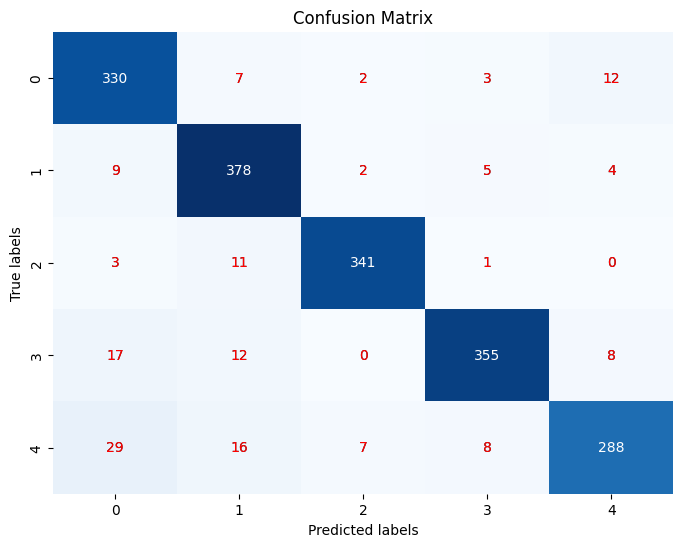

F1 Score: 0.9155039719256404
Sensibilidad (Recall): 0.9155844155844156
Especificidad por clase: [0.9611780455153949, 0.9682758620689655, 0.9926273458445041, 0.9883241758241759, 0.984]
Exactitud: 0.9155844155844156


In [98]:
from sklearn.metrics import confusion_matrix, f1_score, recall_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Obtener predicciones del modelo
y_pred = model.predict(X_test)

# Calcular la matriz de confusión multiclase
conf_matrix = confusion_matrix(y_test, y_pred)

# Calcular métricas adicionales
f1 = f1_score(y_test, y_pred, average='weighted')
sensibilidad = recall_score(y_test, y_pred, average='weighted')
exactitud = accuracy_score(y_test, y_pred)

# Calcular especificidad para cada clase
especificidad = []
for i in range(len(conf_matrix)):
    true_negative = np.sum(np.delete(np.delete(conf_matrix, i, 0), i, 1))
    total_negative = np.sum(np.delete(conf_matrix, i, 0))
    especificidad.append(true_negative / total_negative)

# Visualizar la matriz de confusión con un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)

# Resaltar los valores donde el modelo se confundió
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix)):
        if i != j:
            plt.text(j + 0.5, i + 0.5, conf_matrix[i, j], ha="center", va="center", color="red")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Imprimir métricas
print("F1 Score:", f1)
print("Sensibilidad (Recall):", sensibilidad)
print("Especificidad por clase:", especificidad)
print("Exactitud:", exactitud)


In [110]:
label_mapping = {i: label for i, label in enumerate(encoder.classes_)}
print("Mapeo de etiquetas originales a números codificados:")
for code, label in label_mapping.items():
    print(f"Número codificado {code}: Etiqueta original '{label}'")

Mapeo de etiquetas originales a números codificados:
Número codificado 0: Etiqueta original 'DERECHA'
Número codificado 1: Etiqueta original 'FRENTE'
Número codificado 2: Etiqueta original 'IZQUIERDA'
Número codificado 3: Etiqueta original 'PALANCA'
Número codificado 4: Etiqueta original 'RETROVISOR'


Como se observa en la matriz de confusión la mayoria de las ocasiones el modelo logra clasificar bien, sin embargo este presenta complicaciones entre las clases 0, 1 y 4 (Correspondiente etiqueta en la celda anterior). Esto desde mi punto de vista tiene sentido debido a que estos puntos de atención estan muy cercanos entre si. 

Despues de guardamos el modelo para su posterior implementación en una demo. 

In [99]:
import joblib
joblib.dump(model, './modelos/modelo.pkl')

['./modelos/modelo.pkl']

### Implementación del modelo en tiempo real. 

A continuación se muestra un ejemplo de su implementación en Live Streaming. Que lo disfruten : )

In [103]:
def create_dataframe(temp_landmark_list):
    columnas = [f"k{i}" for i in range(12)]
    datos = [*temp_landmark_list]
    return pd.DataFrame([datos], columns=columnas)

In [105]:
modelo = joblib.load('./modelos/modelo.pkl')
cap = cv2.VideoCapture(0)  # Cambia '0' si tu cámara no es la predeterminada

with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detection:
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            continue

        # Convierte la imagen de BGR a RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        
        # Detección de rostros
        results = face_detection.process(image)

        # Dibuja los resultados de la detección
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        if results.detections:
            for detection in results.detections:
                mp_drawing.draw_detection(image, detection)
                relative_keypoints = detection.location_data.relative_keypoints
                landmark_point = calc_landmark_list(image, relative_keypoints)
                temp_landmark_list = pre_process_landmark(landmark_point)
                X = create_dataframe(temp_landmark_list)
                y_pred = modelo.predict(X)
                y_pred_decoded = encoder.inverse_transform([y_pred])[0]
        cv2.putText(image, y_pred_decoded, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2, cv2.LINE_AA)
                
        # Muestra la imagen
        cv2.imshow('Face Detection', image)
        if cv2.waitKey(1) != -1:  # Si se presiona cualquier tecla, termina la ejecución
            break

cap.release()
cv2.destroyAllWindows()

### Conclusiones. 

Los resultados obenidos empleando utilizando como referencia el tamaño (resolución) del frame resultaron ser de utilidad en el caso del algoritmo K Nearest Neighbors, sin embargo este puede mejorarse aun más. Las confusiones en el modelo pueden deverse a la variación de resolución de los videos, la iluminación o incluso problemas de estimación del bounding_box en el modelo de mediapipe.

Pero creo firmemente en que estos aspectos ayudan mucho a la robustes del modelo y que es necesario tomar más muestras para afinar estos detalles y realizar un entrenamiento con datos balanceados. 